##Import various python functions and modules that we need.

In [2]:
from pandas import DataFrame
from IPython.display import FileLink

##Pylab namespace and inline plots. Import Rmagic.

In [3]:


%matplotlib inline
%load_ext rpy2.ipython

In [4]:
%%R
workDir = '/home/chantal/Chazy/data/'
figDir = '/home/chantal/Chazy/BulkSIP/515_806/figs/'

physeqDir = '/home/chantal/Chazy/data/phyloseq/'
physeqBulkSIP = 'bulkSIP-core'
#physeqBulk = 'bulk-core' 


nprocs = 20

##Import R libraries we'll use.

In [5]:
%%R
library(phyloseq)
library(ggplot2)
library(foreach)
library(doParallel)
library(gridExtra)
library(vegan)
library(dplyr)
library(plyr)
library(RColorBrewer)
library(stats)
library(stringr)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: foreach: simple, scalable parallel programming from Revolution Analytics
Use Revolution R for scalability, fault tolerance and more.
http://www.revolutionanalytics.com

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: iterators

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: parallel

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: permute

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: lattic

##Import data into R. Prune to relevant samples (Chazy). Get rid of OTUs not observed in at least 25% of samples)

In [6]:
%%R

F = file.path(physeqDir, physeqBulkSIP)
physeq.BulkSIP = readRDS(F)
physeq.BulkSIP.m = physeq.BulkSIP %>% sample_data
physeq.BulkSIP

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 16187 taxa and 112 samples ]
sample_data() Sample Data:       [ 112 samples by 25 sample variables ]
tax_table()   Taxonomy Table:    [ 16187 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 16187 tips and 16186 internal nodes ]


In [7]:
%%R

physeq.BulkSIP = prune_samples(physeq.BulkSIP.m$Experiment == 'Chazy_SIP_Bulk_515806'& physeq.BulkSIP.m$Treatment !='H2O',
                               physeq.BulkSIP) %>%
    transform_sample_counts(function(x) x/sum(x))

physeq.BulkSIP.Sparsity = filter_taxa(physeq.BulkSIP, function(x) sum(x > 0) > (0.25 * length(x)), TRUE)

physeq.Bulk.m = physeq.BulkSIP.Sparsity %>% sample_data

    
print(physeq.BulkSIP.Sparsity)


phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3554 taxa and 104 samples ]
sample_data() Sample Data:       [ 104 samples by 25 sample variables ]
tax_table()   Taxonomy Table:    [ 3554 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 3554 tips and 3553 internal nodes ]


### Calculate Unifrac distances between samples.

In [8]:
%%R
registerDoParallel(cores=20)
wunif.dist = distance(physeq.BulkSIP.Sparsity, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

### Adonis Statistics

In [9]:
%%R 
physeq.data = as(sample_data(physeq.BulkSIP.Sparsity), "data.frame")
adonis(wunif.dist ~ Till*Day*Treatment, physeq.data, strata = physeq.data$Replicate)


Call:
adonis(formula = wunif.dist ~ Till * Day * Treatment, data = physeq.data,      strata = physeq.data$Replicate) 

Blocks:  strata 
Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

                    Df SumsOfSqs  MeanSqs F.Model      R2 Pr(>F)    
Till                 1   0.22742 0.227424 19.8778 0.14074  0.001 ***
Day                  1   0.23763 0.237627 20.7696 0.14705  0.001 ***
Treatment            2   0.02169 0.010845  0.9479 0.01342  0.333    
Till:Day             1   0.01889 0.018891  1.6511 0.01169  0.071 .  
Till:Treatment       2   0.00645 0.003226  0.2820 0.00399  0.996    
Day:Treatment        2   0.04622 0.023111  2.0200 0.02860  0.008 ** 
Till:Day:Treatment   2   0.00504 0.002521  0.2203 0.00312  1.000    
Residuals           92   1.05258 0.011441         0.65138           
Total              103   1.61593                  1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


### Separating Samples by Tillage

In [10]:
%%R
    
physeq.BulkSIP.m = physeq.BulkSIP %>% sample_data()
    
physeq.N = prune_samples(physeq.BulkSIP.m$Till =='N',
                               physeq.BulkSIP) 

physeq.P = prune_samples(physeq.BulkSIP.m$Till =='P',
                               physeq.BulkSIP)  
    
print(physeq.N)
print(physeq.P)


phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 16187 taxa and 52 samples ]
sample_data() Sample Data:       [ 52 samples by 25 sample variables ]
tax_table()   Taxonomy Table:    [ 16187 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 16187 tips and 16186 internal nodes ]
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 16187 taxa and 52 samples ]
sample_data() Sample Data:       [ 52 samples by 25 sample variables ]
tax_table()   Taxonomy Table:    [ 16187 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 16187 tips and 16186 internal nodes ]


In [11]:
%%R
registerDoParallel(cores=20)
wunif.P = distance(physeq.P, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

wunif.N = distance(physeq.N, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

In [12]:
%%R 
physeq.data = as(sample_data(physeq.P), "data.frame")
adonis(wunif.P ~ Day*Treatment, physeq.data, strata = physeq.data$Replicate)


Call:
adonis(formula = wunif.P ~ Day * Treatment, data = physeq.data,      strata = physeq.data$Replicate) 

Blocks:  strata 
Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

              Df SumsOfSqs  MeanSqs F.Model      R2 Pr(>F)    
Day            1   0.17983 0.179833 20.3680 0.28593  0.001 ***
Treatment      2   0.01666 0.008330  0.9435 0.02649  0.303    
Day:Treatment  2   0.02630 0.013148  1.4892 0.04181  0.079 .  
Residuals     46   0.40614 0.008829         0.64577           
Total         51   0.62893                  1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [13]:
%%R 
physeq.data = as(sample_data(physeq.N), "data.frame")
adonis(wunif.N ~ Day*Treatment, physeq.data, strata = physeq.data$Replicate)


Call:
adonis(formula = wunif.N ~ Day * Treatment, data = physeq.data,      strata = physeq.data$Replicate) 

Blocks:  strata 
Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

              Df SumsOfSqs  MeanSqs F.Model      R2 Pr(>F)    
Day            1   0.10385 0.103851  5.7308 0.10625  0.001 ***
Treatment      2   0.01243 0.006217  0.3431 0.01272  0.647    
Day:Treatment  2   0.02753 0.013767  0.7597 0.02817  0.038 *  
Residuals     46   0.83360 0.018122         0.85286           
Total         51   0.97742                  1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


### Ordinate using weighted unifrac distnaces with NMDS.

Run 0 stress 0.1976786 
Run 1 stress 0.2488175 
Run 2 stress 0.2010957 
Run 3 stress 0.1936604 
... New best solution
... procrustes: rmse 0.07328252  max resid 0.2762681 
Run 4 stress 0.1982843 
Run 5 stress 0.2282548 
Run 6 stress 0.2346628 
Run 7 stress 0.1871681 
... New best solution
... procrustes: rmse 0.01539186  max resid 0.1527737 
Run 8 stress 0.1992808 
Run 9 stress 0.2021243 
Run 10 stress 0.1880284 
Run 11 stress 0.2032857 
Run 12 stress 0.2077083 
Run 13 stress 0.1997899 
Run 14 stress 0.1972592 
Run 15 stress 0.1992694 
Run 16 stress 0.1877882 
Run 17 stress 0.1871683 
... procrustes: rmse 5.303039e-05  max resid 0.0004100937 
*** Solution reached


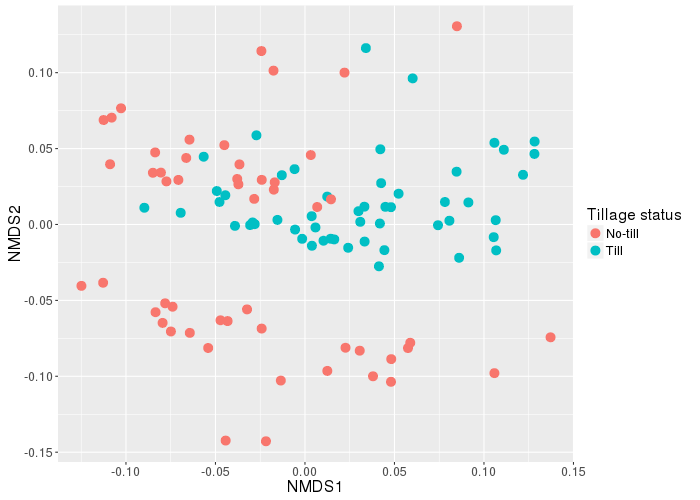

In [14]:
%%R -w 700 -h 500
nmds = ordinate(physeq.BulkSIP, 
                method = "NMDS", 
                distance = wunif.dist)
p.nmds = plot_ordination(physeq.BulkSIP, nmds, justDF = TRUE)
#print(p)


asNumeric = function(x) { as.numeric(as.character(x)) }

p.nmds1 = ggplot(p.nmds, aes(x = NMDS1, y = NMDS2)) +  
        geom_point(aes(color = as.factor(Till)), size = 4) +
        guides(alpha = FALSE, fill=guide_legend(override.aes=list(size=6))) + 
        scale_color_discrete(name = 'Tillage status', labels = c('No-till', 'Till')) + 
        theme(
        text = element_text(size=16))

print(p.nmds1)

In [15]:
%%R
ggsave(filename = "figs/Treatment_ord.png", plot = p.nmds1, width =7, height =5)

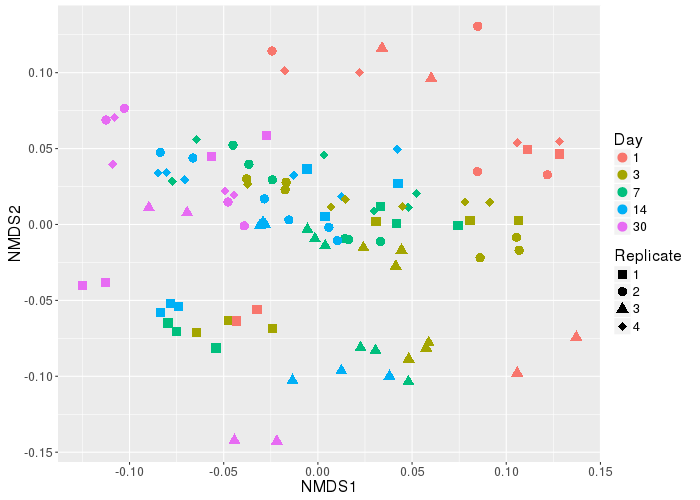

In [16]:
%%R -w 700 -h 500

asNumeric = function(x) { as.numeric(as.character(x)) }

p.nmds1 = ggplot(p.nmds, aes(x = NMDS1, y = NMDS2)) +  
        geom_point(aes(color = as.factor(Day), shape = as.factor(Replicate)), size = 4) +
        guides(alpha = FALSE, fill=guide_legend(override.aes=list(size=6)))+
        scale_shape_manual(values = c(15,16,17,18), name = 'Replicate') +
        scale_color_discrete(name = 'Day') +
        theme(
        text = element_text(size=16))

print(p.nmds1)

In [17]:
%%R
ggsave(filename = "figs/Time_ord.png", plot = p.nmds1, width =7, height =5)

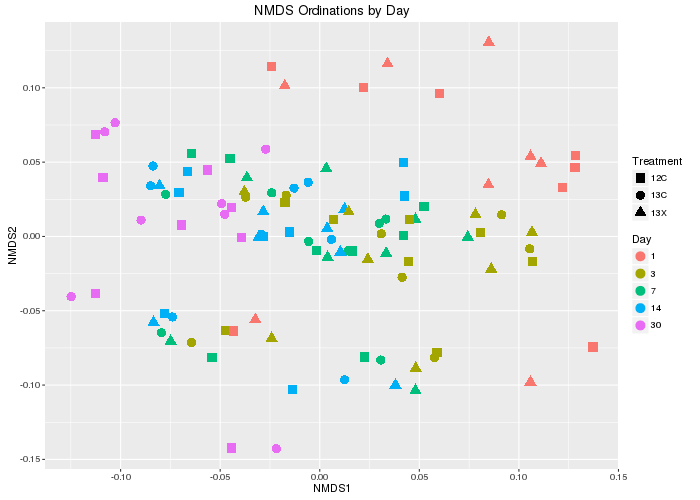

In [16]:
%%R -w 700 -h 500

asNumeric = function(x) { as.numeric(as.character(x)) }

p.nmdsmonth = ggplot(p.nmds, aes(x = NMDS1, y = NMDS2)) +  
        geom_point(aes(color = as.factor(Day), shape = Treatment), size = 4) +
        guides(alpha = FALSE, fill=guide_legend(override.aes=list(size=6)))+
        labs(title="NMDS Ordinations by Day") + scale_shape_manual(values = c(15,16,17,18)) +
        scale_color_discrete(name = 'Day')

print(p.nmdsmonth)

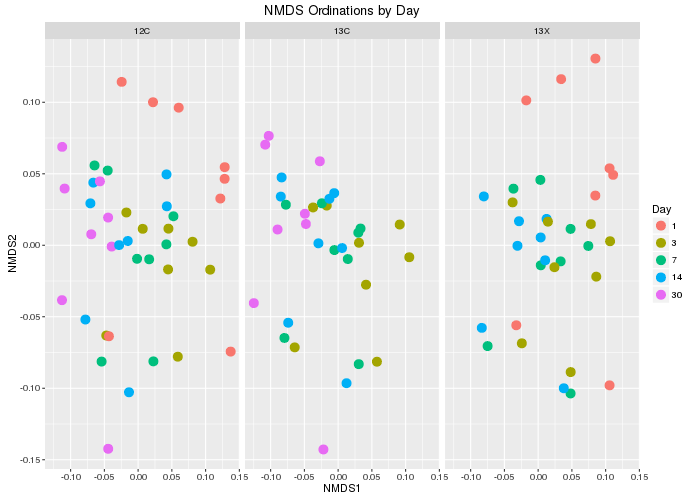

In [17]:
%%R -w 700 -h 500

asNumeric = function(x) { as.numeric(as.character(x)) }

p.nmdsmonth = ggplot(p.nmds, aes(x = NMDS1, y = NMDS2)) +  
        geom_point(aes(color = as.factor(Day)), size = 4) +
        guides(alpha = FALSE, fill=guide_legend(override.aes=list(size=6)))+
        labs(title="NMDS Ordinations by Day") + scale_shape_manual(values = c(15,16,17,18)) +
        scale_color_discrete(name = 'Day') + facet_wrap(~Treatment)

print(p.nmdsmonth)

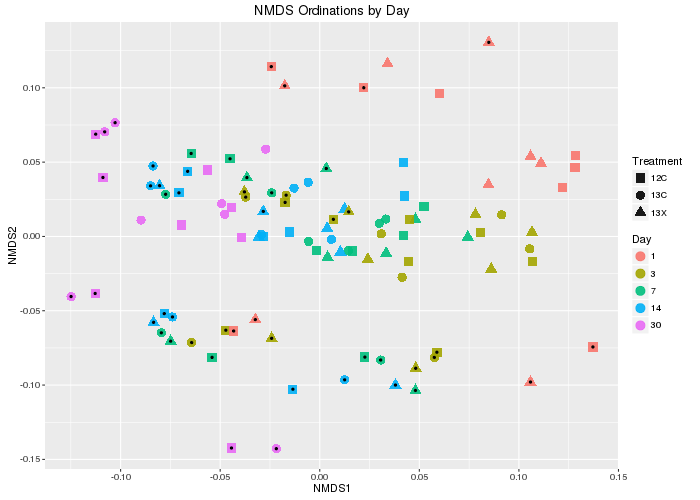

In [18]:
%%R -w 700 -h 500

asNumeric = function(x) { as.numeric(as.character(x)) }

p.nmdsmonth = ggplot(p.nmds, aes(x = NMDS1, y = NMDS2)) +  
        geom_point(aes(color = as.factor(Day), shape = Treatment), size= 4, alpha = 0.9) +
        guides(alpha = FALSE, fill=guide_legend(override.aes=list(size=6)))+
        labs(title="NMDS Ordinations by Day") + scale_shape_manual(values = c(15,16,17,18)) + 
        geom_point(data = subset(p.nmds, Till == 'N'), shape = 20) +
        scale_color_discrete(name = 'Day')

print(p.nmdsmonth)

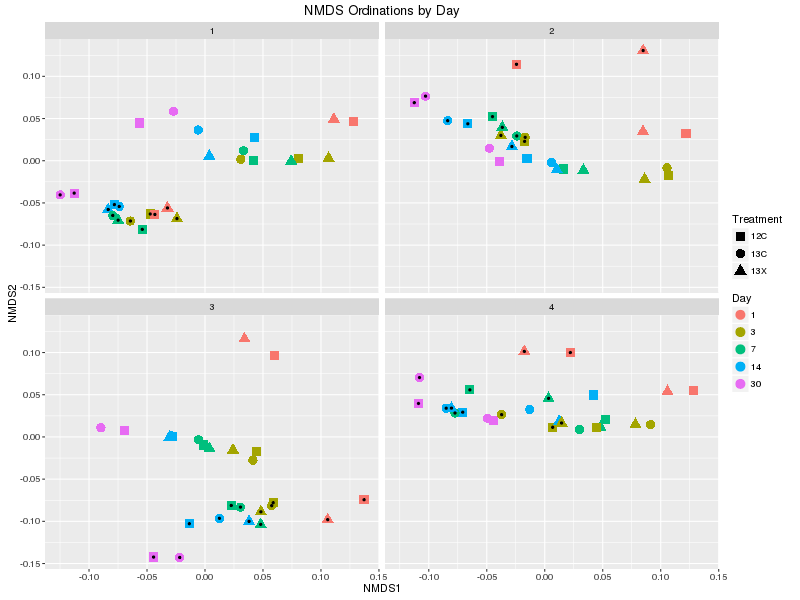

In [19]:
%%R -w 800 -h 600

asNumeric = function(x) { as.numeric(as.character(x)) }

p.nmdsmonth = ggplot(p.nmds, aes(x = NMDS1, y = NMDS2)) +  
        geom_point(aes(color = as.factor(Day), shape = Treatment), size= 4) +
        guides(alpha = FALSE, fill=guide_legend(override.aes=list(size=6)))+
        labs(title="NMDS Ordinations by Day") + scale_shape_manual(values = c(15,16,17,18)) + 
        geom_point(data = subset(p.nmds, Till == 'N'), shape = 20) + facet_wrap(~Replicate)+
        scale_color_discrete(name = 'Day')

print(p.nmdsmonth)

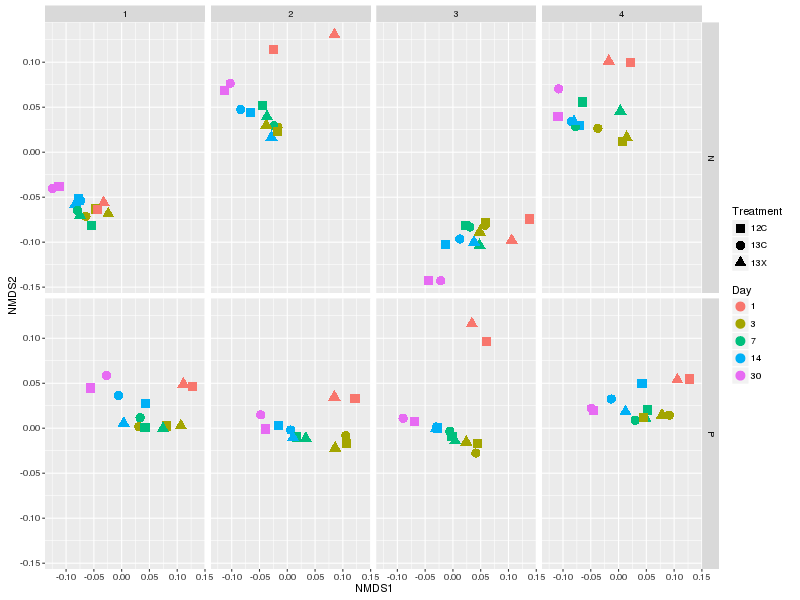

In [20]:
%%R -w 800 -h 600

asNumeric = function(x) { as.numeric(as.character(x)) }

p.nmdsmonth = ggplot(p.nmds, aes(x = NMDS1, y = NMDS2)) +  
        geom_point(aes(color = as.factor(Day), shape = Treatment), size= 4) +
        guides(alpha = FALSE, fill=guide_legend(override.aes=list(size=6)))+
        scale_shape_manual(values = c(15,16,17,18)) + 
        facet_grid(Till~Replicate)+
        scale_color_discrete(name = 'Day')

print(p.nmdsmonth)

In [21]:
%%R
ggsave(filename = "figs/Month_ord.png", plot = p.nmdsmonth, width =7, height =5)

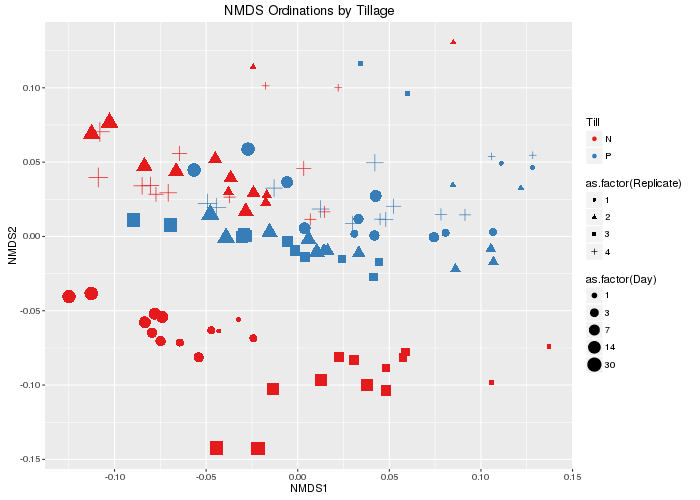

In [22]:
%%R -w 700 -h 500
p.nmds3 = ggplot(p.nmds, aes(x = NMDS1, y = NMDS2)) +  
        geom_point(aes(color = Till, shape = as.factor(Replicate), size = as.factor(Day)))  +
        #facet_wrap(~Day) +
        guides(alpha = FALSE, fill=guide_legend(override.aes=list(size=6)))+
        labs(title="NMDS Ordinations by Tillage")


p.nmds3 = p.nmds3 + scale_color_brewer(palette="Set1")

print(p.nmds3)




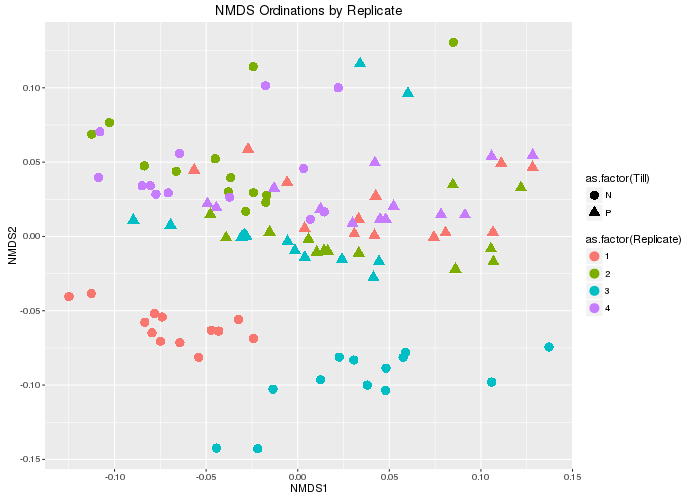

In [23]:
%%R -w 700 -h 500
p.nmds3 = ggplot(p.nmds, aes(x = NMDS1, y = NMDS2)) +  
        geom_point(aes(color = as.factor(Replicate), shape = as.factor(Till)), size = 4)  +
        #facet_wrap(~Day) +
        guides(alpha = FALSE, fill=guide_legend(override.aes=list(size=6)))+
        labs(title="NMDS Ordinations by Replicate")


#p.nmds3 = p.nmds3 + scale_color_brewer(palette="Set1")

print(p.nmds3)




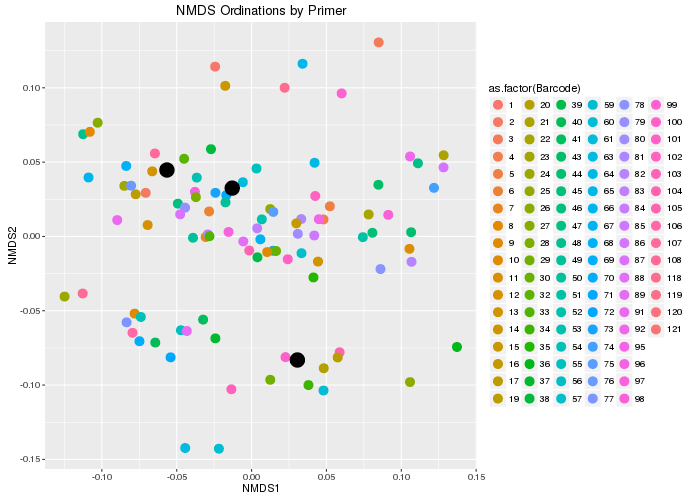

In [24]:
%%R -w 700 -h 500
p.nmds3 = ggplot(p.nmds, aes(x = NMDS1, y = NMDS2)) +  
        geom_point(aes(color = as.factor(Barcode)), size = 4)  +
        guides(alpha = FALSE, fill=guide_legend(override.aes=list(size=6)))+
        labs(title="NMDS Ordinations by Primer")

p.nmds3 = p.nmds3 + geom_point(data = subset(p.nmds, Barcode > 118), shape = 20, size = 10)



 #scale_color_brewer(palette="Set1") + 

print(p.nmds3)



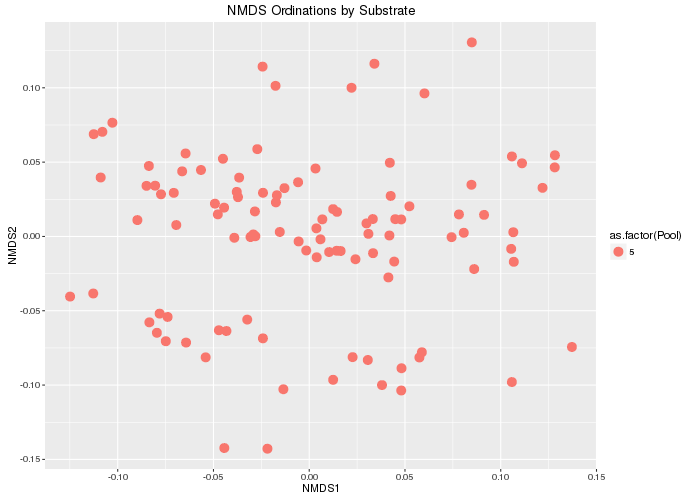

In [25]:
%%R -w 700 -h 500
p.nmds3 = ggplot(p.nmds, aes(x = NMDS1, y = NMDS2)) +  
        geom_point(aes(color = as.factor(Pool)), size = 4)  +
        guides(alpha = FALSE, fill=guide_legend(override.aes=list(size=6)))+
        labs(title="NMDS Ordinations by Substrate")


 #scale_color_brewer(palette="Set1") + 

print(p.nmds3)



In [26]:
%%R
unique(p.nmds$Pool)

[1] 5
